# 🤖 Modelado Predictivo del Dataset

En esta sección se construyen modelos predictivos para estimar la probabilidad de éxito (*target*) de cada candidato.  
El objetivo es:

- Entrenar modelos supervisados que capturen la relación entre variables explicativas y target
- Evaluar la importancia de cada variable
- Comparar distintas técnicas y seleccionar la mejor
- Preparar submodelos según área académica (Medicina, Enfermería, resto)

El proceso se divide en los siguientes pasos:
1. Preparación de datos y división en entrenamiento/test  
2. Selección de modelos factibles  
3. Selección de variables importantes  
4. Entrenamiento de submodelos  
5. Optimización de hiperparámetros  
6. Evaluación del modelo sobre conjunto test

---

## 1️⃣ Preparación de Datos

Antes de entrenar los modelos:

- Se eliminan variables irrelevantes o identificadores
- Se manejan valores nulos
- Se divide el dataset en **conjunto de entrenamiento** (70–80 %) y **conjunto de test** (20–30 %)
- Se crean subdatasets si se requiere segmentación por área académica

📌 Esto asegura que el modelo no vea datos de test durante el entrenamiento, evitando sobreajuste.

---

## 2️⃣ Selección de Modelos

Se consideran modelos supervisados robustos para clasificación/regresión según el target:

- **Random Forest**: Modelo basado en árboles con gran capacidad de generalización  
- **Gradient Boosting Machines (GBM/XGBoost/LightGBM)**: Optimización secuencial de errores  
- **Regresiones**: Lineales o logísticas, útiles para interpretación  
- Otros modelos factibles según el caso (SVM, redes neuronales simples)

Se busca evaluar cuál combina mejor:

- Precisión o % acierto
- AUC (Área bajo la curva ROC)
- Interpretabilidad
- Robustez ante outliers y variables correlacionadas

---

## 3️⃣ Selección de Variables Importantes

- Se utiliza la importancia que cada modelo asigna a las variables para:

  - Reducir dimensionalidad
  - Evitar ruido
  - Mejorar interpretabilidad

- Variables con mayor impacto en la predicción serán prioridad para la construcción de submodelos.

📌 Ejemplo: `feature_importances_` en Random Forest o `SHAP values` para interpretabilidad avanzada.

---

## 4️⃣ Entrenamiento de Submodelos

- Se pueden crear modelos específicos para segmentos de interés:  
  - Medicina  
  - Enfermería  
  - Resto de candidatos

- Esto permite capturar patrones particulares de cada área que un modelo general podría diluir.

---

## 5️⃣ Optimización de Hiperparámetros

- Se aplican técnicas de tuning automático (grid search, random search o frameworks como **PyCaret**)  
- Se buscan combinaciones que maximizan métricas clave:  

  - Precisión / Recall  
  - AUC / ROC  
  - F1-score  

- El objetivo es **obtener el mejor modelo posible** sin sobreajustar a los datos de entrenamiento.

---

## 6️⃣ Evaluación en Conjunto de Test

- Una vez seleccionado el modelo óptimo, se evalúa sobre datos no vistos:

  - Comprobando métricas globales: % acierto, AUC  
  - Detectando posibles sesgos por segmento  
  - Verificando estabilidad y consistencia de predicciones

- Esto garantiza que el modelo generalice y pueda usarse para predicciones futuras.

---

## 🔍 Conclusiones del Modelado

El modelado supervisado permite:

- Predecir con alta fiabilidad la probabilidad de éxito de los candidatos  
- Entender qué variables tienen mayor impacto en la conversión  
- Construir estrategias segmentadas por áreas académicas  
- Complementar el análisis de clusters previo, combinando insights no supervisados y supervisados

📌 Los resultados servirán como base para:

- Implementación de modelos en producción
- Definición de estrategias de admisión diferenciadas
- Análisis de riesgo y priorización de candidatos


✅ Dataset tras excluir Máster: (521101, 52)
✅ Train: (362642, 39) | Test: (105965, 39)


                                    Model  Accuracy     AUC  Recall   Prec.  \
rf               Random Forest Classifier    0.9838  0.9971  0.9756  0.9854   
dt               Decision Tree Classifier    0.9875  0.9952  0.9774  0.9926   
lightgbm  Light Gradient Boosting Machine    0.9268  0.9811  0.9480  0.8847   
lr                    Logistic Regression    0.8883  0.9564  0.8705  0.8629   

              F1   Kappa     MCC  TT (Sec)  
rf        0.9805  0.9667  0.9667    3.7000  
dt        0.9849  0.9743  0.9744    0.6467  
lightgbm  0.9152  0.8509  0.8525    1.0800  
lr        0.8667  0.7706  0.7706    0.4300  


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9132  0.9726  0.9605  0.8506  0.9022  0.8246  0.8295
1       0.9127  0.9731  0.9570  0.8519  0.9014  0.8236  0.8281
2       0.9129  0.9727  0.9605  0.8501  0.9020  0.8242  0.8292
Mean    0.9129  0.9728  0.9593  0.8509  0.9018  0.8241  0.8289
Std     0.0002  0.0002  0.0016  0.0008  0.0003  0.0004  0.0006

🧪 MÉTRICAS EN TEST — Modelo Grado
AUC           : 0.760
Accuracy      : 0.916
Accuracy clase 0 (NO matrícula): 0.907
Accuracy clase 1 (SÍ matrícula): 0.926

📊 MÉTRICAS EN TEST (GRADO)
AUC Test       : 0.760
Accuracy Test  : 0.916
Accuracy Clase 0: 0.907
Accuracy Clase 1: 0.926


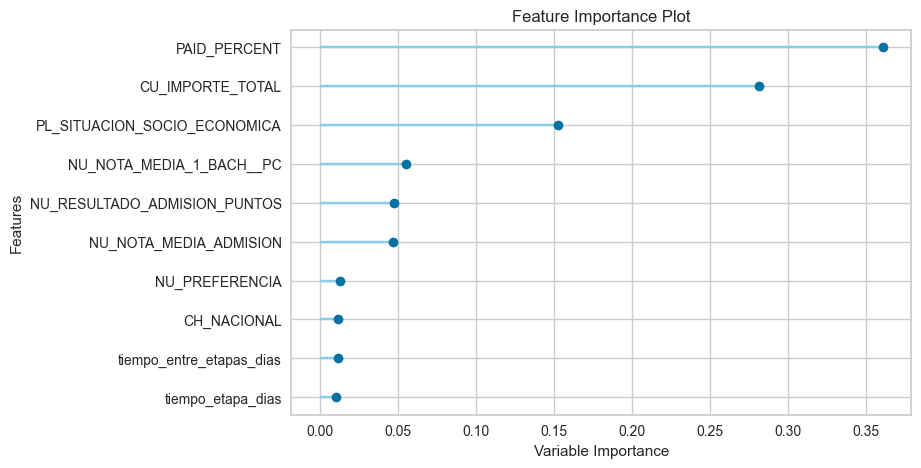

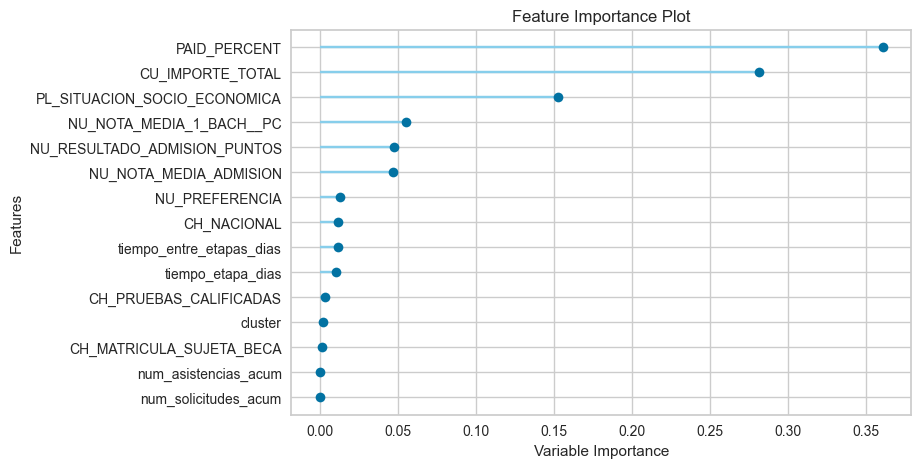

Transformation Pipeline and Model Successfully Saved

✅ Modelo de Grado entrenado, evaluado en TEST y guardado correctamente.


In [5]:
# ============================================================
# SCRIPT · 03 MODELADO PREDICTIVO CON PYCARET (FINAL CORREGIDO)
# ============================================================

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
from pycaret.classification import (
    setup, compare_models, tune_model,
    predict_model, plot_model, save_model
)

def metricas_test(nombre_modelo, preds, y_test, target='target'):
    """
    Calcula métricas clave en el conjunto de test
    """
    # Crear la probabilidad de la clase positiva si no existe
    if 'probabilidad_matricula' not in preds.columns:
        preds['probabilidad_matricula'] = 1 - preds['prediction_score']

    auc = roc_auc_score(y_test, preds['probabilidad_matricula']) \
          if y_test.nunique() > 1 else np.nan

    acc = accuracy_score(y_test, preds['prediction_label'])

    acc_0 = (
        (preds[y_test == 0]['prediction_label'] == 0).mean()
        if (y_test == 0).sum() > 0 else np.nan
    )

    acc_1 = (
        (preds[y_test == 1]['prediction_label'] == 1).mean()
        if (y_test == 1).sum() > 0 else np.nan
    )

    print(f"\n🧪 MÉTRICAS EN TEST — {nombre_modelo}")
    print(f"AUC           : {auc:.3f}")
    print(f"Accuracy      : {acc:.3f}")
    print(f"Accuracy clase 0 (NO matrícula): {acc_0:.3f}")
    print(f"Accuracy clase 1 (SÍ matrícula): {acc_1:.3f}")

    return {
        'Modelo': nombre_modelo,
        'AUC_test': auc,
        'Accuracy_test': acc,
        'Accuracy_0_test': acc_0,
        'Accuracy_1_test': acc_1
    }



# ============================================================
# 0️⃣ CARGA DEL DATASET
# ============================================================

ruta_dataset = r"..\datos\03. Datos analizados\dataset_clusterizado.csv"
df = pd.read_csv(ruta_dataset, sep=";")
target = 'target'

# ============================================================
# 0️⃣.1 FILTRAR SOLO GRADO (EXCLUYE MÁSTER)
# ============================================================

if 'TITULACION' in df.columns:
    df = df[~df['TITULACION'].str.contains('MASTER', case=False, na=False)]
else:
    raise ValueError("❌ No existe la columna TITULACION")

print(f"✅ Dataset tras excluir Máster: {df.shape}")

# ============================================================
# 0️⃣.2 LIMPIEZA BÁSICA
# ============================================================

cols_id = ['ACCOUNTID', 'ID', 'ID18__PC', 'BIRTHDATE']

#Copiamos el dataset completo antes de eliminar columnas
df_full = df.copy()

df = df.drop(columns=[c for c in cols_id if c in df.columns])
df = df.dropna(subset=[target])

# ============================================================
# 0️⃣.3 IMPUTACIÓN LÓGICA DE NA
# ============================================================

vars_cero_logico = [
    'NU_NOTA_MEDIA_ADMISION',
    'NU_NOTA_MEDIA_1_BACH__PC',
    'NU_RESULTADO_ADMISION_PUNTOS',
    'CU_IMPORTE_TOTAL',
    'CU_precioOrdinario_def__c',
    'CU_precioAplicado_def__c',
    'PAID_PERCENT'
]

for v in vars_cero_logico:
    if v in df.columns:
        df[v] = df[v].fillna(0)

df = df.fillna(0)

# ============================================================
# 1️⃣ SELECCIÓN DE VARIABLES
# ============================================================

vars_excluir = [
    'desmatriculado', 'MINIMUMPAYMENTPAYED',
    'CH_PAGO_SUPERIOR', 'STAGENAME', 'PL_SUBETAPA',
    'ACC_DTT_FECHAULTIMAACTIVIDAD', 'NAMEX',
    'YEARPERSONBIRTHDATE', 'PAID_AMOUNT',
    'PC1', 'PC2'
]

vars_modelado = [c for c in df.columns if c not in vars_excluir + [target]]

# ============================================================
# 2️⃣ SPLIT TEMPORAL
# ============================================================

cursos = df['PL_CURSO_ACADEMICO'].dropna().sort_values().unique()
curso_test = cursos[-2]
curso_excluido = cursos[-1]

train_df_full = df[~df['PL_CURSO_ACADEMICO'].isin([curso_test, curso_excluido])]
test_df_full_model = df[df['PL_CURSO_ACADEMICO'] == curso_test]

test_df_full_excel = (
    df_full[df_full['PL_CURSO_ACADEMICO'] == curso_test]
    .reset_index(drop=True)
)


X_train = train_df_full[vars_modelado]
y_train = train_df_full[target]
X_test  = test_df_full_model[vars_modelado]
y_test  = test_df_full_model[target]


print(f"✅ Train: {X_train.shape} | Test: {X_test.shape}")

# ============================================================
# 3️⃣ FILTRADO DE COLUMNAS PROBLEMÁTICAS
# ============================================================

object_cols = X_train.select_dtypes(include='object').columns.tolist()
const_cols = X_train.columns[X_train.nunique() <= 1].tolist()
pca_cols = ['PCA1', 'PCA2', 'PC1', 'PC2']

safe_cols = [
    c for c in X_train.columns
    if c not in object_cols + const_cols + pca_cols
]

train_df = X_train[safe_cols].copy()
train_df[target] = y_train

# ============================================================
# 4️⃣ SETUP PYCARET
# ============================================================

setup(
    data=train_df,
    target=target,
    session_id=42,
    normalize=True,
    fold=3,
    pca=False,
    remove_multicollinearity=False,
    verbose=False,
    html=False
)

# ============================================================
# 5️⃣ MODELADO
# ============================================================

best_model = compare_models(
    include=['lr', 'dt', 'rf', 'lightgbm'],
    sort='AUC',
    turbo=True
)

best_model = tune_model(best_model, optimize='AUC', n_iter=10)

# ============================================================
# 6️⃣ VALIDACIÓN EN TEST (CLAVE PARA JUAN)
# ============================================================

test_df = test_df_full_model[safe_cols].reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

preds = predict_model(best_model, data=test_df)
preds[target] = y_test

metricas_master = metricas_test(
    nombre_modelo="Modelo Grado",
    preds=preds,
    y_test=y_test,
    target=target
)

preds['prob_matricula_real'] = preds.apply(
    lambda x: x['prediction_score'] if x['prediction_label'] == 1 
    else (1 - x['prediction_score']),
    axis=1
)

auc_test = roc_auc_score(y_test, preds['probabilidad_matricula'])

acc_test = accuracy_score(y_test, preds['prediction_label'])

acc_0 = (preds[preds[target] == 0]['prediction_label'] == 0).mean()
acc_1 = (preds[preds[target] == 1]['prediction_label'] == 1).mean()

print("\n📊 MÉTRICAS EN TEST (GRADO)")
print(f"AUC Test       : {auc_test:.3f}")
print(f"Accuracy Test  : {acc_test:.3f}")
print(f"Accuracy Clase 0: {acc_0:.3f}")
print(f"Accuracy Clase 1: {acc_1:.3f}")

# ============================================================
# 7️⃣ DATASET TEST COMPLETO CON SCORING
# ============================================================

df_test_completo = pd.concat(
    [
        test_df_full_excel,
        preds[['prediction_label', 'prob_matricula_real']]
    ],
    axis=1
)

assert len(test_df_full_excel) == len(preds), "❌ Desalineación filas test vs preds"

ruta_excel = r"..\datos\03. Datos analizados\test_grado_completo_con_scoring.xlsx"
df_test_completo.to_excel(ruta_excel, index=False)

# ============================================================
# 8️⃣ IMPORTANCIA DE VARIABLES
# ============================================================

plot_model(best_model, plot='feature')
plot_model(best_model, plot='feature_all')

# ============================================================
# 9️⃣ GUARDADO DEL MODELO
# ============================================================

save_model(best_model, r"..\datos\04. Modelos\modelo_final_grado")

print("\n✅ Modelo de Grado entrenado, evaluado en TEST y guardado correctamente.")


✅ Dataset Máster: (15503, 52)
✅ Train Máster: (10381, 37) | Test Máster: (3681, 37)


                                    Model  Accuracy     AUC  Recall   Prec.  \
lightgbm  Light Gradient Boosting Machine    0.9865  0.9994  0.9821  0.9956   

              F1   Kappa    MCC  TT (Sec)  
lightgbm  0.9888  0.9719  0.972    0.3867  


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9860  0.9992  0.9796  0.9972  0.9883  0.9707  0.9710
1       0.9872  0.9993  0.9864  0.9925  0.9894  0.9732  0.9733
2       0.9835  0.9987  0.9782  0.9945  0.9863  0.9656  0.9658
Mean    0.9855  0.9991  0.9814  0.9947  0.9880  0.9698  0.9700
Std     0.0015  0.0002  0.0036  0.0020  0.0013  0.0032  0.0031

🧪 MÉTRICAS EN TEST — Modelo Máster
AUC           : 0.719
Accuracy      : 0.919
Accuracy clase 0 (NO matrícula): 0.911
Accuracy clase 1 (SÍ matrícula): 0.925


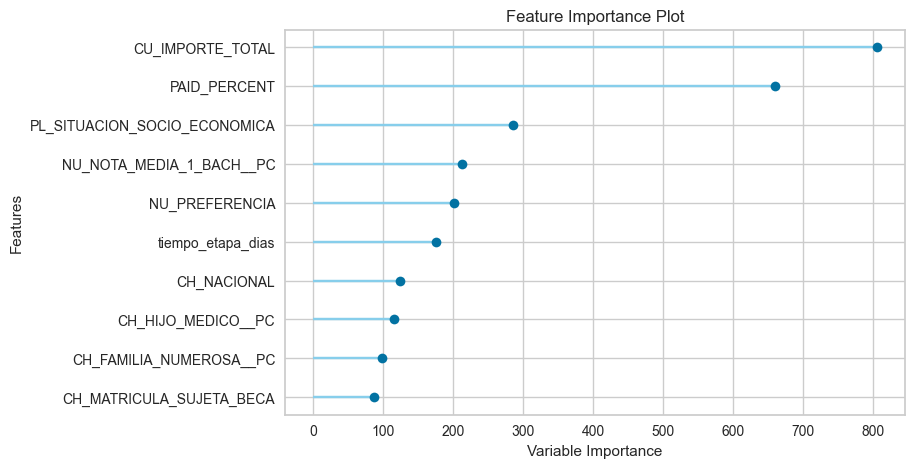

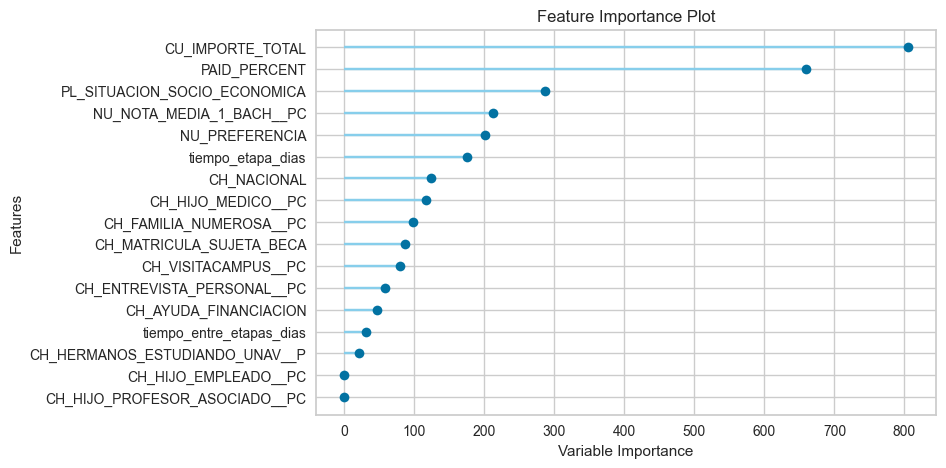

Transformation Pipeline and Model Successfully Saved

✅ Modelo Máster entrenado, evaluado en TEST y guardado correctamente.


In [6]:
# ============================================================
# SCRIPT · MODELADO PREDICTIVO MÁSTER CON PYCARET (FINAL CORREGIDO)
# ============================================================

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
from pycaret.classification import (
    setup, compare_models, tune_model,
    predict_model, plot_model, save_model
)

# ============================================================
# FUNCIÓN MÉTRICAS TEST
# ============================================================

def metricas_test(nombre_modelo, preds, y_test, target='target'):
    auc = roc_auc_score(y_test, preds['prediction_score']) \
          if y_test.nunique() > 1 else np.nan

    acc = accuracy_score(y_test, preds['prediction_label'])

    acc_0 = (
        (preds[y_test == 0]['prediction_label'] == 0).mean()
        if (y_test == 0).sum() > 0 else np.nan
    )

    acc_1 = (
        (preds[y_test == 1]['prediction_label'] == 1).mean()
        if (y_test == 1).sum() > 0 else np.nan
    )

    print(f"\n🧪 MÉTRICAS EN TEST — {nombre_modelo}")
    print(f"AUC           : {auc:.3f}")
    print(f"Accuracy      : {acc:.3f}")
    print(f"Accuracy clase 0 (NO matrícula): {acc_0:.3f}")
    print(f"Accuracy clase 1 (SÍ matrícula): {acc_1:.3f}")

    return {
        'Modelo': nombre_modelo,
        'AUC_test': auc,
        'Accuracy_test': acc,
        'Accuracy_0_test': acc_0,
        'Accuracy_1_test': acc_1
    }

# ============================================================
# 0️⃣ CARGA DATASET
# ============================================================

ruta_dataset = r"..\datos\03. Datos analizados\dataset_clusterizado.csv"
df = pd.read_csv(ruta_dataset, sep=";")
target = 'target'

# ============================================================
# 0️⃣.1 FILTRAR SOLO MÁSTER
# ============================================================

df = df[df['TITULACION'].str.contains('MASTER', case=False, na=False)]
print(f"✅ Dataset Máster: {df.shape}")

# ============================================================
# 0️⃣.2 LIMPIEZA E IMPUTACIÓN
# ============================================================

cols_id = ['ACCOUNTID', 'ID', 'ID18__PC', 'BIRTHDATE']

df_full = df.copy()  

df = df.drop(columns=cols_id, errors='ignore')
df = df.dropna(subset=[target])


vars_cero_logico = [
    'NU_NOTA_MEDIA_ADMISION',
    'NU_NOTA_MEDIA_1_BACH__PC',
    'NU_RESULTADO_ADMISION_PUNTOS',
    'CU_IMPORTE_TOTAL',
    'CU_precioOrdinario_def__c',
    'CU_precioAplicado_def__c',
    'PAID_PERCENT'
]

for v in vars_cero_logico:
    if v in df.columns:
        df[v] = df[v].fillna(0)

df = df.fillna(0)

# ============================================================
# 1️⃣ VARIABLES (EXCLUSIÓN ROBUSTA)
# ============================================================

vars_excluir = [
    'desmatriculado', 'MINIMUMPAYMENTPAYED', 'CH_PAGO_SUPERIOR',
    'STAGENAME', 'PL_SUBETAPA', 'ACC_DTT_FECHAULTIMAACTIVIDAD',
    'NAMEX', 'YEARPERSONBIRTHDATE', 'PAID_AMOUNT'
]

# ❌ Eliminar cualquier PC / PCA
vars_excluir += [c for c in df.columns if c.upper().startswith('PC')]

vars_modelado = [c for c in df.columns if c not in vars_excluir + [target]]

# ============================================================
# 2️⃣ SPLIT TEMPORAL
# ============================================================

cursos = df['PL_CURSO_ACADEMICO'].dropna().sort_values().unique()
curso_test = cursos[-2]
curso_excluido = cursos[-1]

train_df_full = df[~df['PL_CURSO_ACADEMICO'].isin([curso_test, curso_excluido])]
test_df_full_model = df[df['PL_CURSO_ACADEMICO'] == curso_test]

test_df_full_excel = (
    df_full[df_full['PL_CURSO_ACADEMICO'] == curso_test]
    .reset_index(drop=True)
)


X_train = train_df_full[vars_modelado]
y_train = train_df_full[target]
X_test  = test_df_full_model[vars_modelado]
y_test  = test_df_full_model[target]


print(f"✅ Train Máster: {X_train.shape} | Test Máster: {X_test.shape}")

# ============================================================
# 3️⃣ FILTRADO FINAL (BLINDADO)
# ============================================================

object_cols = X_train.select_dtypes(include='object').columns.tolist()
const_cols = X_train.columns[X_train.nunique() <= 1].tolist()
pca_cols = [c for c in X_train.columns if c.upper().startswith('PC')]

safe_cols = [
    c for c in X_train.columns
    if c not in object_cols + const_cols + pca_cols
]

train_df = X_train[safe_cols].copy()
train_df[target] = y_train

# ============================================================
# 4️⃣ PYCARET
# ============================================================

setup(
    data=train_df,
    target=target,
    session_id=42,
    normalize=True,
    fold=3,
    pca=False,
    verbose=False,
    html=False
)

best_model = compare_models(include=['lightgbm'], sort='AUC')
best_model = tune_model(best_model, optimize='AUC')

# ============================================================
# 5️⃣ VALIDACIÓN EN TEST
# ============================================================

test_df = X_test[safe_cols].reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

preds = predict_model(best_model, data=test_df)
preds[target] = y_test

preds['prob_matricula_real'] = preds.apply(
    lambda x: x['prediction_score'] if x['prediction_label'] == 1 
    else (1 - x['prediction_score']),
    axis=1
)


metricas_master = metricas_test(
    nombre_modelo="Modelo Máster",
    preds=preds,
    y_test=y_test,
    target=target
)

# ============================================================
# 6️⃣ DATASET TEST COMPLETO
# ============================================================

df_test_completo = pd.concat(
    [
        test_df_full_excel,
        preds[['prediction_label', 'prob_matricula_real']]
    ],
    axis=1
)

assert len(test_df_full_excel) == len(preds), "❌ Desalineación test vs preds"


ruta_excel = r"..\datos\03. Datos analizados\test_master_completo_con_scoring.xlsx"
df_test_completo.to_excel(ruta_excel, index=False)

# ============================================================
# 7️⃣ IMPORTANCIA Y GUARDADO
# ============================================================

plot_model(best_model, plot='feature')
plot_model(best_model, plot='feature_all')

save_model(best_model, r"..\datos\04. Modelos\modelo_final_master")

print("\n✅ Modelo Máster entrenado, evaluado en TEST y guardado correctamente.")


In [ ]:
# ============================================================
# 🔹 ANÁLISIS EXPLORATORIO Y CONSTRUCCIÓN DE VARIABLES ORDINARIAS
# ============================================================

print(df.columns.tolist())
# Revisar variable "Visita Campus" en GRADO
if 'CH_VISITACAMPUS__PC' in df.columns:
    vc_counts = df['CH_VISITACAMPUS__PC'].value_counts(dropna=False)
    vc_perc = df['CH_VISITACAMPUS__PC'].value_counts(normalize=True, dropna=False) * 100
    print("\n📌 Visita Campus - Distribución")
    print(vc_counts)
    print(vc_perc)

    if 'CH_VISITACAMPUS__PC' in safe_cols:
        print("✅ Visita Campus entra en el modelo")
    else:
        print("❌ Visita Campus NO entra en el modelo")


else:
    print("❌ La variable 'Visita Campus' no está en el dataset.")

# Revisar variable "antiguo alumno" en MÁSTER
if 'antiguo_alumno' in df.columns:
    aa_counts = df['antiguo_alumno'].value_counts(dropna=False)
    aa_perc = df['antiguo_alumno'].value_counts(normalize=True, dropna=False) * 100
    print("\n📌 Antiguo alumno - Distribución")
    print(aa_counts)
    print(aa_perc)
else:
    print("❌ La variable 'antiguo_alumno' no está en el dataset.")

# Revisar "renta" y "% de beca"
for var in ['FO_rentaFam_ges__c', 'CH_MATRICULA_SUJETA_BECA']:
    if var in df.columns:
        na_count = df[var].isna().sum()
        na_perc = df[var].isna().mean() * 100

        print(f"\n📌 {var}")
        print(f"NA: {na_count} filas ({na_perc:.2f}%)")

        if na_perc > 20:
            print("⚠️ Alto porcentaje de NA → variable candidata a descarte o imputación avanzada")
        elif na_perc > 0:
            print("💡 Posible imputación por media/mediana + flag de missing")
    else:
        print(f"❌ La variable '{var}' no está en el dataset.")


# Combinamos STAGENAME + PL_SUBETAPA
# ============================================================
# 🔹 CONSTRUCCIÓN VARIABLE ORDINAL DE ETAPAS
# ============================================================

if 'STAGENAME' in df.columns and 'PL_SUBETAPA' in df.columns:

    df['etapa_compuesta'] = (
        df['STAGENAME'].astype(str) + "__" + df['PL_SUBETAPA'].astype(str)
    )

    # Orden lógico del proceso (AJUSTAR A NEGOCIO)
    orden_etapas = {
        'Lead__Inicial': 1,
        'Lead__Contactado': 2,
        'Admisión__Entrevista': 3,
        'Admisión__Admitido': 4,
        'Matrícula__Pendiente Pago': 5,
        'Matrícula__Pagada': 6
    }

    df['etapa_ordinal_num'] = df['etapa_compuesta'].map(orden_etapas)

    print("\n📌 Variable ordinal 'etapa_ordinal_num' creada")
    print(df[['STAGENAME', 'PL_SUBETAPA', 'etapa_compuesta', 'etapa_ordinal_num']].head(10))

else:
    print("❌ No existen STAGENAME o PL_SUBETAPA para construir la ordinal.")



['target', 'desmatriculado', 'PL_CURSO_ACADEMICO', 'CH_NACIONAL', 'NU_NOTA_MEDIA_ADMISION', 'NU_NOTA_MEDIA_1_BACH__PC', 'CH_PRUEBAS_CALIFICADAS', 'NU_RESULTADO_ADMISION_PUNTOS', 'PL_RESOLUCION_DEFINITIVA', 'TITULACION', 'CENTROENSENANZA', 'MINIMUMPAYMENTPAYED', 'PAID_AMOUNT', 'PAID_PERCENT', 'CH_PAGO_SUPERIOR', 'CH_MATRICULA_SUJETA_BECA', 'CH_AYUDA_FINANCIACION', 'CU_IMPORTE_TOTAL', 'CH_VISITACAMPUS__PC', 'CH_ENTREVISTA_PERSONAL__PC', 'ACC_DTT_FECHAULTIMAACTIVIDAD', 'NU_PREFERENCIA', 'STAGENAME', 'PL_SUBETAPA', 'CH_HIJO_EMPLEADO__PC', 'CH_HIJO_PROFESOR_ASOCIADO__PC', 'CH_HERMANOS_ESTUDIANDO_UNAV__P', 'CH_HIJO_MEDICO__PC', 'YEARPERSONBIRTHDATE', 'NAMEX', 'CH_FAMILIA_NUMEROSA__PC', 'PL_SITUACION_SOCIO_ECONOMICA', 'LEADSOURCE', 'PL_ORIGEN_DE_SOLICITUD', 'PL_PLAZO_ADMISION', 'RECORDTYPENAME', 'PLAZO_ADMISION_LIMPIO', 'FO_rentaFam_ges__c', 'CU_precioOrdinario_def__c', 'CU_precioAplicado_def__c', 'PORCENTAJE_PAGADO_FINAL', 'tiempo_etapa_dias', 'tiempo_entre_etapas_dias', 'num_asistencias_acu